# Imports

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections

# Degree Network

Create a network with a desired degree - code start taken from lecture and ChatGPT was used to help create a working version. Link to chat: https://chat.openai.com/share/6d50a46c-cb21-4e5d-9173-7e5b37c031d3


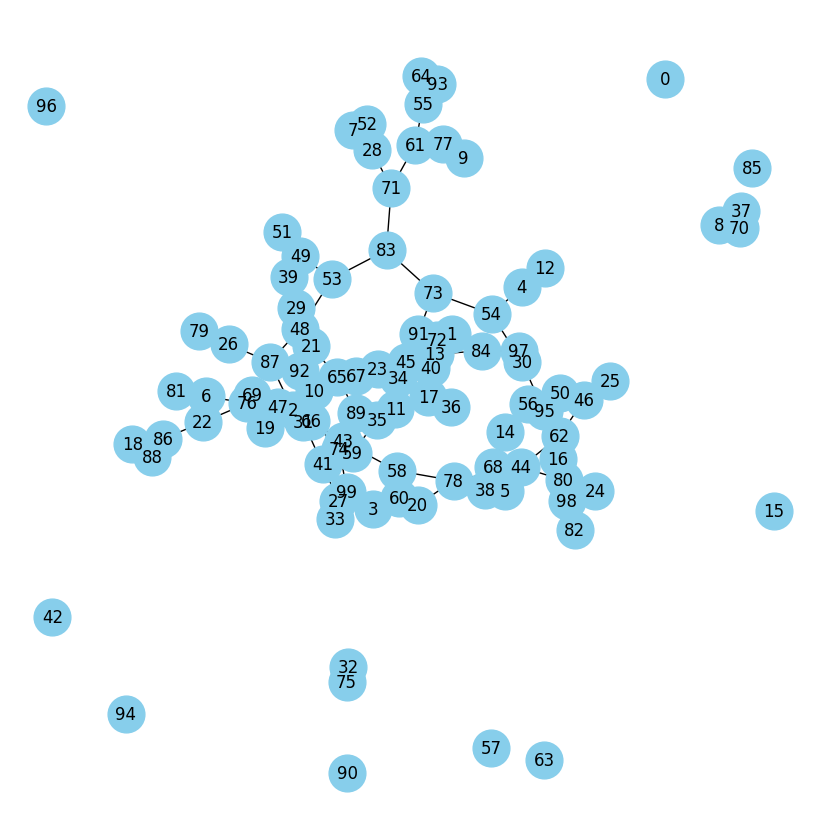

In [2]:


def configuration_A(S):
    """Configuration model with degree sequence S"""
    stubs = []
    for i in range(len(S)):
        for j in range(S[i]):
            stubs.append(i)
    n = nx.Graph()
    n.add_nodes_from(range(len(S)))  # Ensure the graph has len(S) nodes
    while len(stubs) > 1:  # Need at least 2 stubs to form an edge
        v, w = random.sample(stubs, 2)
        if v != w:  # Avoid self-loops
            n.add_edge(v, w)
            # Remove v, w from stubs
            stubs.remove(v)
            stubs.remove(w)
    return n

def configuration_B(n, P):
    """Configuration model with degree distribution P"""
    S = [1]
    while not nx.is_valid_degree_sequence_erdos_gallai(S):
        S = random.choices(population=range(len(P)), weights=P, k=n)
    return configuration_A(S)
def plot_graph(G):
    """Plot the given graph G using matplotlib"""
    plt.figure(figsize=(8, 8))
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, edge_color='k')
    plt.show()


def plot_degree_distribution(G, P):
    """Plot the degree distribution of graph G and compare it with distribution P"""
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    # Also plot the theoretical distribution P for comparison
    theoretical_degrees = range(len(P))
    plt.plot(theoretical_degrees, [p*n for p in P], 'r-', label='Theoretical distribution')
    plt.legend()
    plt.show()



n = 100  # Number of nodes
P = [0.1, 0.2, 0.3, 0.4]  # Example distribution for demonstration


graph = configuration_B(n, P)
plot_graph(graph)

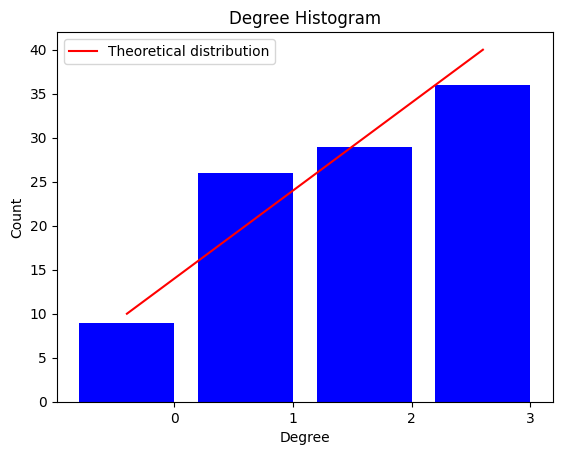

In [3]:
plot_degree_distribution(graph, P)

# Model3

Fits clustering and check with r and d

In [4]:
import networkx as nx
import random
import time
import signal

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

def model3(G, c_current, cluster, allowed_error, nodes_per_round, seed=42):
    # Seed the random number generator for reproducibility
    random.seed(seed)
    
    c_steps = [c_current]
    cluster_bound = [cluster - allowed_error, cluster + allowed_error]
    i = 0
    start_time = time.time()

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(5400)  # Set the alarm for one and a half hours

    try:
        while c_current < cluster_bound[0] or c_current > cluster_bound[1]:
            i += 1
            node_list = list(G.nodes())  # Refresh the node list

            # Ensure all nodes are connected to the largest component if not connected
            if not nx.is_connected(G):
                largest_cc = max(nx.connected_components(G), key=len)
                for node in node_list:
                    if node not in largest_cc:
                        G.add_edge(node, random.choice(list(largest_cc)))

            for node in node_list:
                if node not in G:
                    continue  # Ensure node still exists

                current_links = list(G.neighbors(node))
                node_degree = G.degree(node)

                if current_links:
                    # Randomly selects one link to remove
                    link_to_remove = random.choice(current_links)
                    degree_of_removed_node = G.degree(link_to_remove)  # Degree of the node at the other end of the removed link
                    G.remove_edge(node, link_to_remove)

                # Filter nodes with similar degree to the removed node's degree
                possible_new_links = [n for n in node_list if G.degree(n) == degree_of_removed_node and n != node]

                if len(possible_new_links) > nodes_per_round:
                    selected_nodes = random.sample(possible_new_links, nodes_per_round)
                else:
                    selected_nodes = possible_new_links

                c_possible = []

                for possible in selected_nodes:
                    G.add_edge(node, possible)
                    new_c = nx.average_clustering(G)
                    c_possible.append(new_c)
                    G.remove_edge(node, possible)

                if c_possible:
                    best_node = selected_nodes[c_possible.index(max(c_possible))]
                    G.add_edge(node, best_node)

            c_current = nx.average_clustering(G)
            c_steps.append(c_current)

        signal.alarm(0)  # Disable the alarm
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps

    except TimeoutException:
        print("Function execution failed due to timeout.")
        execution_time = time.time() - start_time
        print(f"Total execution time: {execution_time:.2f} seconds")
        return G, i, c_steps  # Returning the graph, iteration count, and clustering steps so far

# Example usage:
# G = nx.complete_graph(50)  # or any other graph initialization
# result = model3(G, nx.average_clustering(G), 0.6, 0.02, 5)

In [5]:
# check how good the model is


def analyze_graph(G):
    # Check if the graph is connected; this is required to compute the diameter
    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f"Diameter of the graph: {diameter}")
    else:
        print("Graph is not connected; diameter of the giant component will be calculated.")
        # Find the largest connected component (giant component)
        giant_component = max(nx.connected_components(G), key=len)
        G_giant = G.subgraph(giant_component).copy()

        # Diameter of the giant component
        diameter = nx.diameter(G_giant)
        print(f"Diameter of the giant component: {diameter}")


    # Average Clustering Coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average Clustering Coefficient: {avg_clustering}")

    # Degree Distribution
    degrees = [G.degree(n) for n in G.nodes()]
    degree_counts = np.bincount(degrees)
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(degree_counts)), degree_counts, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()


In [6]:
import pandas as pd
# Meet's stuff
Sydney = pd.read_csv("Sydney.csv")
SiouxFalls = pd.read_csv("SiouxFalls.csv")
Anaheim = pd.read_csv("Anaheim.csv")
BerlinFriedrichshain = pd.read_csv("Berlin-Friedrichshain.csv")
BerlinMitteCenter = pd.read_csv("Berlin-Mitte-Center.csv")
Barcelona = pd.read_csv("Barcelona.csv")
EasternMassachusetts = pd.read_csv("Eastern-Massachusetts.csv")
Winnipeg = pd.read_csv("Winnipeg.csv")

In [7]:
ana_net = bar_net = bf_net = bmc_net = em_net = sioux_net = syd_net = win_net = nx.Graph()

places = [Anaheim, Barcelona, BerlinFriedrichshain, BerlinMitteCenter, EasternMassachusetts, SiouxFalls, Sydney, Winnipeg]
graphs = [ana_net, bar_net, bf_net, bmc_net, em_net, sioux_net, syd_net, win_net]

for i in range(len(places)):
  for idx, row in places[i].iterrows():
    graphs[i].add_edge(row['init_node'], row['term_node'], **row.drop(['init_node', 'term_node']).to_dict())

In [8]:
# get a degree distribution from Eastern Massachusetts
em_degrees = [em_net.degree(n) for n in em_net.nodes()]
em_degree_counts = np.bincount(em_degrees)

In [9]:
# make that random model with that
em_graph = configuration_B(74, em_degree_counts)

In [10]:
em_graph_avg = nx.average_clustering(em_graph)

In [11]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2869
em_model, em_i, em_c_steps = model3(em_graph, em_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.04 seconds


In [12]:
em_model

In [13]:
em_i

73019

In [14]:
em_c_steps

[0.06104986693221987,
 0.13323680823680822,
 0.016409266409266408,
 0.09826254826254827,
 0.12583655083655082,
 0.10278850278850278,
 0.059009009009009,
 0.05926640926640926,
 0.03758043758043759,
 0.07335907335907334,
 0.14253539253539255,
 0.05357142857142858,
 0.08974688974688974,
 0.04804804804804804,
 0.07480694980694982,
 0.06460746460746462,
 0.07785285285285286,
 0.08276490776490777,
 0.07681252681252679,
 0.11034963534963535,
 0.07432432432432433,
 0.05225225225225225,
 0.09496996996996997,
 0.06756756756756757,
 0.11103603603603604,
 0.13188545688545686,
 0.06102531102531102,
 0.08262548262548264,
 0.028571428571428577,
 0.03648648648648649,
 0.08186400686400686,
 0.0929214929214929,
 0.05292792792792793,
 0.058515658515658514,
 0.09465894465894466,
 0.0619047619047619,
 0.10337837837837838,
 0.14533462033462036,
 0.04954954954954955,
 0.022072072072072072,
 0.0761904761904762,
 0.08104890604890605,
 0.03738738738738739,
 0.1266194766194766,
 0.038803088803088796,
 0.07761690

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 11
Average Clustering Coefficient: 0.07406692406692407


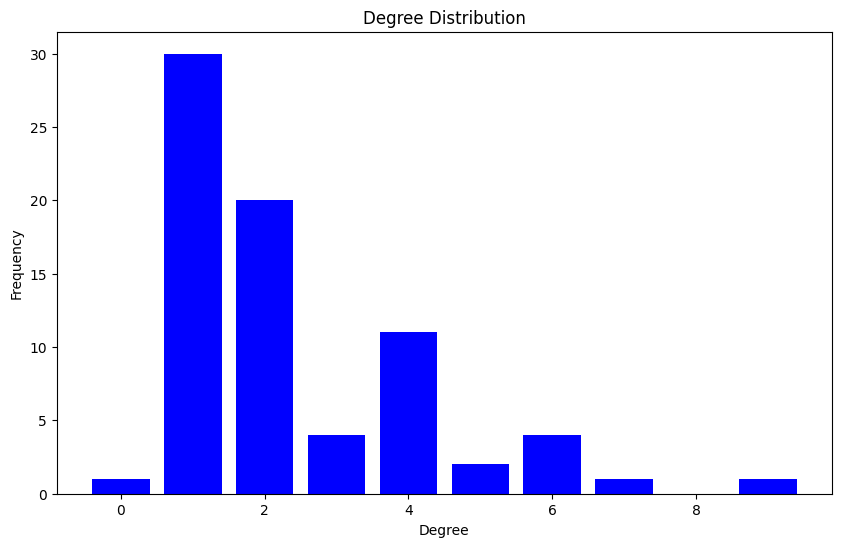

In [15]:
# compare calculated d and r values with actual values
analyze_graph(em_model)

In [16]:
nx.degree_assortativity_coefficient(em_model)

-0.1482625267785108

In [17]:
# get a degree distribution from Sioux Falls
sioux_degrees = [sioux_net.degree(n) for n in sioux_net.nodes()]
sioux_degree_counts = np.bincount(sioux_degrees)

In [18]:
# make that random model with that
sioux_graph = configuration_B(24, sioux_degree_counts)

In [19]:
sioux_graph_avg = nx.average_clustering(sioux_graph)

In [20]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0528
sioux_model, sioux_i, sioux_c_steps = model3(sioux_graph, sioux_graph_avg, c, c * 0.1, 5)

Total execution time: 0.10 seconds


In [21]:
sioux_model

In [22]:
sioux_i

16

In [23]:
sioux_c_steps

[0.0,
 0.0,
 0.12916666666666668,
 0.0,
 0.17916666666666667,
 0.0625,
 0.0,
 0.08472222222222221,
 0.0,
 0.18888888888888888,
 0.027777777777777776,
 0.125,
 0.07361111111111111,
 0.0,
 0.09027777777777779,
 0.12222222222222223,
 0.051388888888888894]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 6
Average Clustering Coefficient: 0.051388888888888894


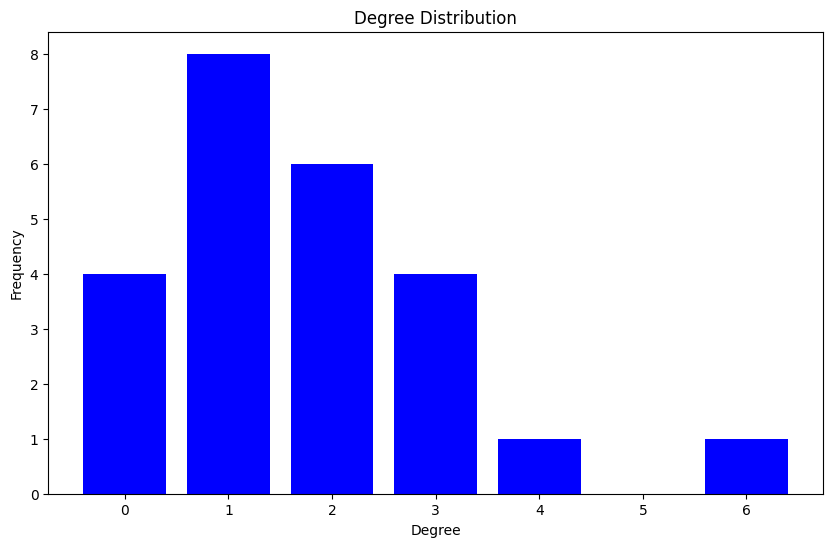

In [24]:
# compare calculated d and r values with actual values
analyze_graph(sioux_model)

In [25]:
nx.degree_assortativity_coefficient(sioux_model)

-0.22598870056497206

In [26]:
# get a degree distribution from Barcelona
bar_degrees = [bar_net.degree(n) for n in bar_net.nodes()]
bar_degree_counts = np.bincount(bar_degrees)

In [27]:
# make that random model with that
bar_graph = configuration_B(1020, bar_degree_counts)

In [28]:
bar_graph_avg = nx.average_clustering(bar_graph)

In [29]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0902
bar_model, bar_i, bar_c_steps = model3(bar_graph, bar_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.08 seconds


In [30]:
bar_model

In [31]:
bar_i

192

In [32]:
bar_c_steps

[0.0024478915190989494,
 0.008603742150454953,
 0.015415554745139523,
 0.018614598908716553,
 0.021312629924221622,
 0.02393621164814936,
 0.02764514352749647,
 0.0235200801377272,
 0.03094139248551015,
 0.02841812779415222,
 0.026893813906910438,
 0.027113747987480105,
 0.03241239026404278,
 0.0323437716449305,
 0.032658021118820636,
 0.032475507893432926,
 0.040144305183673984,
 0.03689936585301927,
 0.04040022007990745,
 0.03371443355012649,
 0.03516986726308043,
 0.03790993173990982,
 0.041990007971960695,
 0.03758052268335832,
 0.04132578377641452,
 0.04135451500448841,
 0.03245033061938198,
 0.03583366353402239,
 0.03734176488301292,
 0.0364285292774659,
 0.03837075851438557,
 0.04938613278339956,
 0.04161205684699934,
 0.04496918992483414,
 0.04031770050744413,
 0.042420392558498096,
 0.04949745344717759,
 0.04483437631793811,
 0.036254064689572325,
 0.042705917733392273,
 0.0350755306211963,
 0.03766137296749384,
 0.03944377295310909,
 0.0500610674069385,
 0.04479769581825986,


Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.03617484284241883


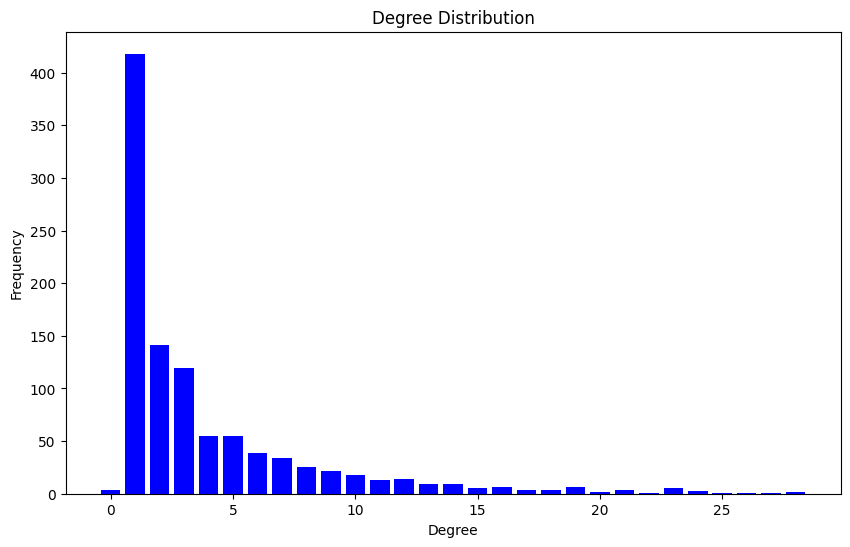

In [33]:
# compare calculated d and r values with actual values
analyze_graph(bar_model)

In [34]:
nx.degree_assortativity_coefficient(bar_model)

-0.45055034679311545

In [35]:
# get a degree distribution from Sydney
syd_degrees = [syd_net.degree(n) for n in syd_net.nodes()]
syd_degree_counts = np.bincount(syd_degrees)

In [36]:
# make that random model with that
syd_graph = configuration_B(33837, syd_degree_counts)

In [37]:
syd_graph_avg = nx.average_clustering(syd_graph)

In [38]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.0074
syd_model, syd_i, syd_c_steps = model3(syd_graph, syd_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.04 seconds


In [39]:
syd_model

In [40]:
syd_i

1

In [41]:
syd_c_steps

[0.00012093501484591583]

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 30
Average Clustering Coefficient: 0.00020527852782485282


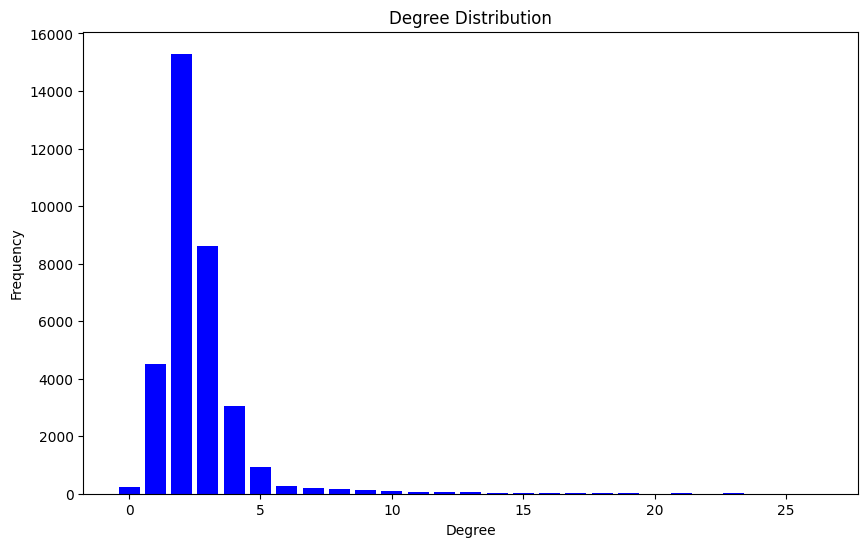

In [42]:
# compare calculated d and r values with actual values
analyze_graph(syd_model)

In [43]:
nx.degree_assortativity_coefficient(syd_model)

-0.018385756280742356

In [44]:
# get a degree distribution from Winnipeg
win_degrees = [win_net.degree(n) for n in win_net.nodes()]
win_degree_counts = np.bincount(win_degrees)

In [45]:
# make that random model with that
win_graph = configuration_B(1052, win_degree_counts)

In [46]:
win_graph_avg = nx.average_clustering(win_graph)

In [47]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1045
win_model, win_i, win_c_steps = model3(win_graph, win_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.05 seconds


In [48]:
win_model

In [49]:
win_i

181

In [50]:
win_c_steps

[0.0008296644653458743,
 0.010774600129610191,
 0.01788384830209926,
 0.014976832419798199,
 0.024100122801475977,
 0.02204569722793893,
 0.026789533871282932,
 0.026897635589247623,
 0.01570551069125213,
 0.029537176791132134,
 0.03694498904065825,
 0.033247240365923365,
 0.03569500198362751,
 0.032358855513630755,
 0.030951323570351536,
 0.029178916368906842,
 0.03902574789570228,
 0.039214291387183416,
 0.038186025453266915,
 0.03319542514818572,
 0.03570084448630701,
 0.0358781629824115,
 0.03400935145296661,
 0.03370839505745645,
 0.04016642283506756,
 0.033390497417031026,
 0.040072537397063235,
 0.04429649422239291,
 0.03022372573871121,
 0.040462922029184084,
 0.03985499153864436,
 0.03971491572003099,
 0.05023447475740793,
 0.04150241599060895,
 0.03296360055272566,
 0.04502021120705574,
 0.04179673904909053,
 0.041524440490981245,
 0.04121675718065684,
 0.043606932039728326,
 0.03766684437620956,
 0.041083969489884416,
 0.04684913177037809,
 0.032145043237098755,
 0.044344518

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 8
Average Clustering Coefficient: 0.03660716173903501


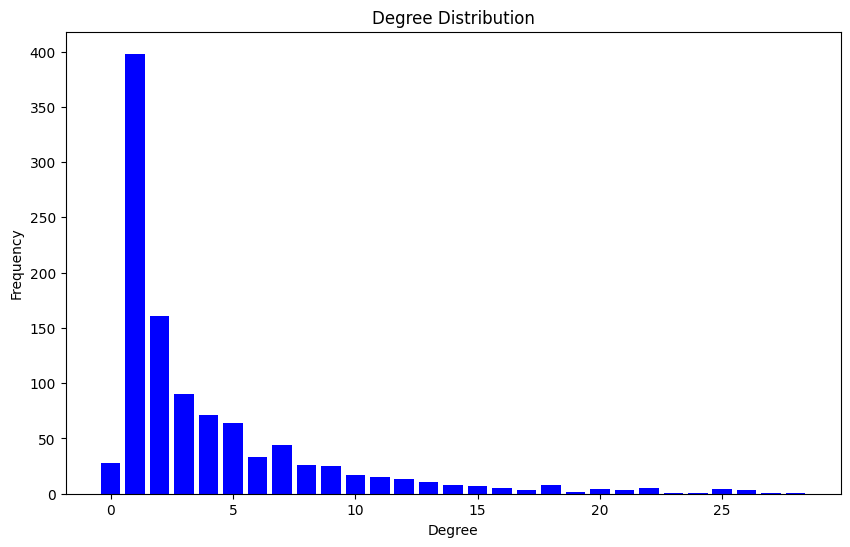

In [51]:
# compare calculated d and r values with actual values
analyze_graph(win_model)

In [52]:
nx.degree_assortativity_coefficient(win_model)

-0.42968763387190956

In [53]:
# get a degree distribution from Anaheim
ana_degrees = [ana_net.degree(n) for n in ana_net.nodes()]
ana_degree_counts = np.bincount(ana_degrees)

In [54]:
# make that random model with that
ana_graph = configuration_B(416, ana_degree_counts)

In [55]:
ana_graph_avg = nx.average_clustering(ana_graph)

In [56]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1076
ana_model, ana_i, ana_c_steps = model3(ana_graph, ana_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.05 seconds


In [57]:
ana_model

In [58]:
ana_i

1659

In [59]:
ana_c_steps

[0.00862984013287657,
 0.04044317061143984,
 0.045861603674103676,
 0.030876361885977255,
 0.03562572576995654,
 0.03358620546120546,
 0.05825660050419665,
 0.04303751803751803,
 0.05351379193644464,
 0.043177222083472085,
 0.04135956936791212,
 0.048330780503433236,
 0.06099763421596001,
 0.05992589416302652,
 0.06278256999410846,
 0.04989629957460841,
 0.045752250725346985,
 0.04688172875390069,
 0.0343651446592623,
 0.03621543141406503,
 0.05118460599229831,
 0.04812346166277162,
 0.04636074591886245,
 0.06096726575021258,
 0.04868007848423569,
 0.05928536832732772,
 0.06058226932728305,
 0.04035928406686325,
 0.04086582488024795,
 0.056927970612218326,
 0.0610953894961248,
 0.042919447790771295,
 0.04712956059463411,
 0.04494446063085917,
 0.049213605150472545,
 0.05181782920976777,
 0.054161079280527366,
 0.0719477359147891,
 0.0516656714797269,
 0.053975769862364895,
 0.05935757147578416,
 0.04279390206638508,
 0.06341150394384797,
 0.042831384801757216,
 0.05920809684596451,
 0.

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.05941383894858679


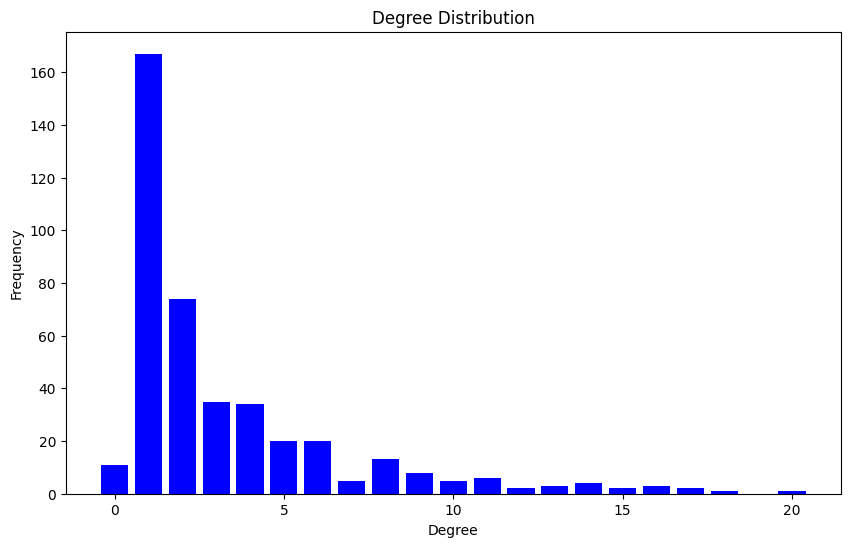

In [60]:
# compare calculated d and r values with actual values
analyze_graph(ana_model)

In [61]:
nx.degree_assortativity_coefficient(ana_model)

-0.4285096078220895

In [62]:
# get a degree distribution from BerlinFriedrichshain
bf_degrees = [bf_net.degree(n) for n in bf_net.nodes()]
bf_degree_counts = np.bincount(bf_degrees)

In [63]:
# make that random model with that
bf_graph = configuration_B(224, bf_degree_counts)

In [64]:
bf_graph_avg = nx.average_clustering(bf_graph)

In [65]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.1915
bf_model, bf_i, bf_c_steps = model3(bf_graph, bf_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.07 seconds


In [66]:
bf_model

In [67]:
bf_i

6998

In [68]:
bf_c_steps

[0.007339032104069698,
 0.06772324460087063,
 0.047047149279292134,
 0.05294687950937949,
 0.062372126881055444,
 0.04266185203685203,
 0.06036577509791795,
 0.05708079123257694,
 0.05362199804164088,
 0.05310693770515198,
 0.07691016820481104,
 0.04103309884559884,
 0.08966098385741242,
 0.05184948979591836,
 0.05590148938363223,
 0.05783284176141319,
 0.07072770979020977,
 0.06418967936825079,
 0.06099270273377416,
 0.0796501365697794,
 0.07610137877995019,
 0.08673709722816866,
 0.08517251597608737,
 0.06570104003139718,
 0.051290227629513345,
 0.07836625180375179,
 0.05432427195820053,
 0.06068346336203477,
 0.0596964047856905,
 0.0904518348714777,
 0.06702682238396523,
 0.0700709260977118,
 0.023337203471132044,
 0.050223263839335286,
 0.05051332595975452,
 0.05566539115646258,
 0.049172776628133776,
 0.08246624407338692,
 0.04925830617794903,
 0.03888177794427794,
 0.06722739066489064,
 0.054799813281956114,
 0.07000177401963116,
 0.08672485748378604,
 0.06020945820052962,
 0.071

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.07021693584193582


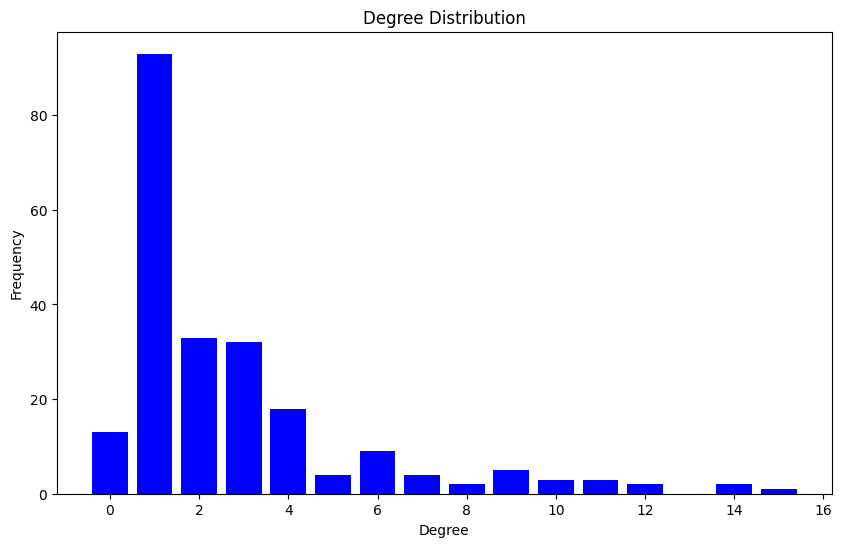

In [69]:
# compare calculated d and r values with actual values
analyze_graph(bf_model)

In [70]:
nx.degree_assortativity_coefficient(bf_model)

-0.38741732154499425

In [71]:
# get a degree distribution from Berlin-Mitte-Center
bmc_degrees = [bmc_net.degree(n) for n in bmc_net.nodes()]
bmc_degree_counts = np.bincount(bmc_degrees)

In [72]:
# make that random model with that
bmc_graph = configuration_B(398, bmc_degree_counts)

In [73]:
bmc_graph_avg = nx.average_clustering(bmc_graph)

In [74]:
# plug that into the fitting algorithm (nodes per round as 5)
c = 0.2048
bmc_model, bmc_i, bmc_c_steps = model3(bmc_graph, bmc_graph_avg, c, c * 0.1, 5)

Function execution failed due to timeout.
Total execution time: 5400.08 seconds


In [75]:
bmc_model

In [76]:
bmc_i

1778

In [77]:
bmc_c_steps

[0.014111958016037238,
 0.029465178792698752,
 0.03482564336835692,
 0.029637127250192567,
 0.03686814302392191,
 0.037479368760775796,
 0.05313668046080105,
 0.039828108797958034,
 0.03824416584171239,
 0.04834240093994749,
 0.032930826276229765,
 0.08070588884954832,
 0.06612384971090263,
 0.04410162291480646,
 0.04954535479956706,
 0.047900135385355626,
 0.05757066979724385,
 0.03838638411872227,
 0.05457140233459913,
 0.055546208479995064,
 0.05568750476376842,
 0.057022019839785144,
 0.04418175809770003,
 0.05499676531305262,
 0.045815887646363546,
 0.046896517037663954,
 0.0598172416639753,
 0.03908630453856584,
 0.04941338305527675,
 0.03872087571836315,
 0.05497070445496788,
 0.0510181282572651,
 0.0440090460686864,
 0.0712378402298591,
 0.04413220085330638,
 0.06135273783888376,
 0.06050852947098884,
 0.051684803710411654,
 0.053337863758387415,
 0.059237851762977405,
 0.04037892470127171,
 0.047064335499934565,
 0.05175334157746216,
 0.04774586311314068,
 0.059319355170709444

Graph is not connected; diameter of the giant component will be calculated.
Diameter of the giant component: 9
Average Clustering Coefficient: 0.04619473991702783


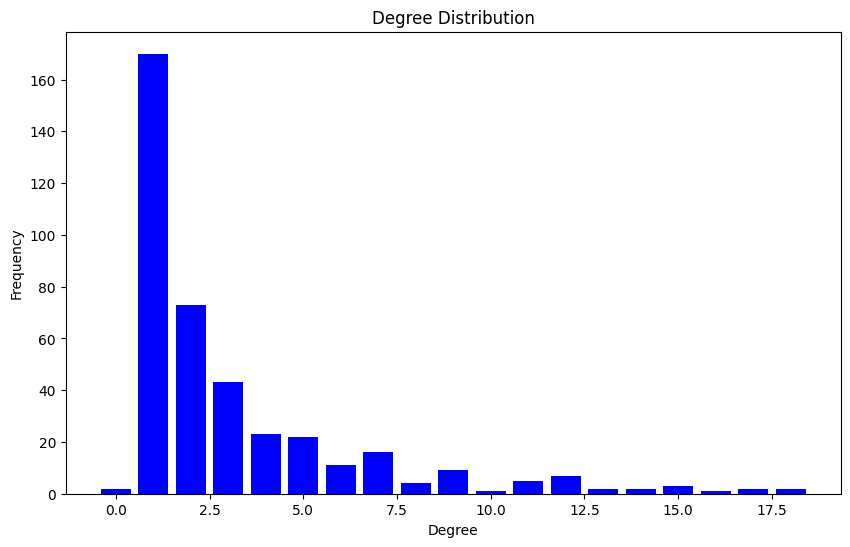

In [78]:
# compare calculated d and r values with actual values
analyze_graph(bmc_model)

In [79]:
nx.degree_assortativity_coefficient(bmc_model)

-0.3828385027105764